## Introduction 

This notebook serves as our first approach of study by further cleaning up the data, studying the dataset itself and conducting overall exploratory data analysis (EDA) on it. 

<div class="alert alert-block alert-info">
<h3> Content </h3>
    <ol>
        <li>Data Preparation</li>
        <li>Datasets Overview & Merging</li>
        <li>Exploratory Data Analysis on the population
            <ul>
                <li>Distribution of User Demographics</li>
                <li>Distribution of genres among demographic groups</li>
            </ul>
        </li>
        <li>Correlation Study</li>
        <li>Chi Square Test</li>
        <li>Conclusion</li>
    </ol>
</div>

## 1. Data Preparation

### Import Packages

In [0]:
import nltk
import pandas as pd
nltk.download("popular")
from collections import Counter
import matplotlib.pyplot as plt
#!pip install textblob
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from pandas import DataFrame
import scipy.stats as stats
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Change to dataset directory
cd '/content/gdrive/My Drive/bt4222'

/content/gdrive/My Drive/bt4222


#### Clean Movie Metadata

In [0]:
master_movies_df = pd.read_csv('movie_data_merged_v1.csv')
genome = pd.read_csv('genome-scores.csv')
tags = pd.read_csv('genome_tags.csv')

In [0]:
# merging relevant genome tags of each movie
df2 = pd.merge(genome, tags)

## add the genome_tags as a feature in master_movie_df
# 0.7 to be the threshold for relevant tags 
df2 = df2[df2.relevance >= 0.7] 
movie_tag = pd.DataFrame(df2.groupby('movieId')['tag'].unique()).reset_index()
movie_tag.columns = ['movie_id', 'tags']
master_movies_df = pd.merge(master_movies_df, movie_tag, on='movie_id', how='inner')

# rename tags_y column name to tags
master_movies_df.rename(columns={'tags': 'tags'}, inplace=True)

In [0]:
# genre_label
# get rid punctuations 
# lowercase
master_movies_df['genre_label'] = master_movies_df['genre_label'].map(lambda a: a.replace("|", " ").replace("-", ""))
master_movies_df['Cast_clean'] = master_movies_df['Cast'].map(lambda a: a.replace(" ", "").replace(",", " ") if type(a) == str else "na" ) # join all non-NAs cast names together
master_movies_df['Director_clean'] = master_movies_df['Director'].map(lambda a: a.replace(" ", "").replace(",", " ") if type(a) == str else "na" ) # join all non-NAs director names together
master_movies_df['tags_clean'] = master_movies_df['tags'].apply(lambda x: [word.replace("-", "") for word in x])
master_movies_df['tags_clean'] = master_movies_df['tags_clean'].apply(func=lambda x: ",".join(x))

In [0]:
# function to join cast names together
def join_names(x):
    rubbish_names = ["Narrateby", "(voiceof)", "(voices)", "voicesof"]
    xsplit = x.split(" ")
    
    if "Jr." in xsplit:
        newstr = []
        idx = 0
        for idx2 in range(len(xsplit)):
            if xsplit[idx2] == "Jr.":
                join = xsplit[idx2-1] + xsplit[idx2]
                
                # if there is more than 1 'Jr.' in the list 
                # check if this is the 1st 'Jr.', append everything from start (0) to idx2-1
                # if there is more than 1 'Jr.', append everything from the last index which 'Jr.' was to end
                if idx == 0:
                    newstr += xsplit[idx:idx2-1] + [join]
                else:
                    newstr += xsplit[idx+1:idx2-1] + [join]
                idx = idx2
                
        newstr += xsplit[idx+1:] # append names after 'Jr.' if there is no more 'Jr.' to be found
        
        # check for non-name entities inside cleaned cast names
        checker = [0 for x in range(len(newstr))]
        for idx in range(len(newstr)):
            for rubbish_name in rubbish_names:
                if newstr[idx].find(rubbish_name) != -1:
                    newstr[idx] = newstr[idx].replace(rubbish_name, "")
        
        return " ".join(newstr)      
    
    else: 
        # check for non-name entities inside cleaned cast names
        for idx in range(len(xsplit)):
            for rubbish_name in rubbish_names:
                if xsplit[idx].find(rubbish_name) != -1:
                    xsplit[idx] = xsplit[idx].replace(rubbish_name, "")
                
        return " ".join(xsplit) 

In [0]:
master_movies_df['Cast_clean'] = master_movies_df['Cast_clean'].apply(func = lambda x: join_names(x))
master_movies_df['Director_clean'] = master_movies_df['Director_clean'].apply(func = lambda x: join_names(x))

In [0]:
# save dataframe as csv
master_movies_df.to_csv('movie_data_merged_v2.csv', sep='\t', encoding='utf-8')

<div class="alert alert-block alert-info">
Certain columns of our movie metadata dataset needs to be further process to facilitate our analysis process later on. These columns includes *Genre labels*, *Casts*, *Directors* and *Tags*. The cleaning process involves removing certain puchuations such as '-', '|', ',' and whitespaces and joining of the words to form a string of text. Checking of noise such as text which is not a Cast/Director name has to be removed as well. 
</div>

### Read in Datasets

In [0]:
master_movies_df = pd.read_csv('movie_data_merged_v2.csv')
master_ratings_df_full = pd.read_csv('user_ratings.csv')
user_demo_df = pd.read_csv('users.csv').set_index("userid", drop=True)
del master_movies_df['Unnamed: 0']

## 2. Datasets Overview & Merging 

In [0]:
master_ratings_df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500100 entries, 0 to 500099
Data columns (total 4 columns):
user      500100 non-null int64
movie     500100 non-null int64
rating    500100 non-null int64
id        500100 non-null object
dtypes: int64(3), object(1)
memory usage: 15.3+ MB


In [0]:
master_ratings_df_full.describe()

,user,movie,rating
count,500100.000000,500100.000000,500100.000000
mean,4408.620518,1834.281214,3.602224
std,926.274862,1076.388887,1.114688
min,2783.000000,1.000000,1.000000
25%,3622.000000,1022.000000,3.000000
50%,4371.000000,1767.000000,4.000000
75%,5220.000000,2724.000000,4.000000
max,6040.000000,3952.000000,5.000000


In [0]:
master_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3078 entries, 0 to 3077
Data columns (total 13 columns):
movie_id                3078 non-null int64
movie_name              3078 non-null object
movie_name_corrected    3078 non-null object
year                    3078 non-null int64
genre_label             3078 non-null object
Director                3076 non-null object
Cast                    3043 non-null object
Wiki Page               3078 non-null object
Plot                    3078 non-null object
tags                    3078 non-null object
Cast_clean              3078 non-null object
Director_clean          3078 non-null object
tags_clean              3078 non-null object
dtypes: int64(2), object(11)
memory usage: 336.7+ KB


In [0]:
user_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user          6040 non-null int64
gender        6040 non-null object
age           6040 non-null int64
occupation    6040 non-null int64
zip_code      6040 non-null object
dtypes: int64(3), object(2)
memory usage: 236.0+ KB


In [0]:
area_list = ['east', 'east', 'east', 'south-east', 'east', 
            'north-east', 'central', 'south', 'south-west',
            'west']
def assign_area(zc, area_list):
    first_digit = int(zc[0])
    return area_list[first_digit]
user_demo_df['zip_code_area'] =user_demo_df['zip_code'].apply(func=lambda x: assign_area(x, area_list))

<div class="alert alert-block alert-info">
From the information about the datasets, we can see there are quite a number of variables in the master_movie_df that are non-numeric and two variables (directors and cast) contain null values. This suggests that we are dealing with categorical variables and necessary transformations should be considered. 
</div>

### Merging of User Demographics and Movie metadata datasets
<div class="alert alert-block alert-info">
Since we would like to study what are the factors affecting the rating given by a user to a movie, it would be better to have the datasets merged which makes the following EDA easier. 
</div>

In [0]:
# merge user_info and rating_df by user_id
merged_df=pd.merge(user_demo_df,master_ratings_df_full,on="user",how="right")

In [0]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500100 entries, 0 to 500099
Data columns (total 9 columns):
user             500100 non-null int64
gender           500100 non-null object
age              500100 non-null int64
occupation       500100 non-null int64
zip_code         500100 non-null object
zip_code_area    500100 non-null object
movie            500100 non-null int64
rating           500100 non-null int64
id               500100 non-null object
dtypes: int64(5), object(4)
memory usage: 38.2+ MB


In [0]:
merged_df['movie_id']=merged_df['movie']

In [0]:
master_movies_df.tags.head()

0    [adventure, animated, animation, cartoon, cgi,...
1    [adventure, animals, based on a book, big budg...
2    [comedy, good sequel, original, romance, seque...
3         [chick flick, girlie movie, romantic, women]
4    [comedy, family, father daughter relationship,...
Name: tags, dtype: object

In [0]:
# Create new columns in movie_info for the sentiment and polarity scores
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    blob = TextBlob(text)
    # return the polarity
    return round(blob.sentiment.polarity, 2)

# define a function that accepts text and returns the subjectivity
def detect_subjectivity(text):
    blob = TextBlob(text)
    # return the polarity
    return round(blob.sentiment.subjectivity, 2)

In [0]:
# The polarity score is a float within the range [-1.0, 1.0]. 
# The subjectivity is a float within the range [0.0, 1.0] 
# where 0.0 is very objective and 1.0 is very subjective.

master_movies_df['sentiment'] = master_movies_df.tags_clean.apply(detect_sentiment)
master_movies_df['subjectivity'] = master_movies_df.tags_clean.apply(detect_subjectivity)

In [0]:
# Prepare subset of movie_info to merge with merged_df
movie_subset=master_movies_df[['movie_id','movie_name_corrected','year','genre_label','Director','Cast_clean','Director_clean','sentiment','subjectivity']]
# Merge the movie_subset with merged_df 
master_data=pd.merge(movie_subset,merged_df,on="movie_id",how="left")

<div class="alert alert-block alert-info">
For the rest of our EDA, we will be focusing on the **master_data** dataset which includes all the variables we have about movies and users.
</div>

In [0]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481408 entries, 0 to 481407
Data columns (total 18 columns):
movie_id                481408 non-null int64
movie_name_corrected    481408 non-null object
year                    481408 non-null int64
genre_label             481408 non-null object
Director                481403 non-null object
Cast_clean              481408 non-null object
Director_clean          481408 non-null object
sentiment               481408 non-null float64
subjectivity            481408 non-null float64
user                    481355 non-null float64
gender                  481355 non-null object
age                     481355 non-null float64
occupation              481355 non-null float64
zip_code                481355 non-null object
zip_code_area           481355 non-null object
movie                   481355 non-null float64
rating                  481355 non-null float64
id                      481355 non-null object
dtypes: float64(7), int64(2), object(9

In [0]:
master_data.describe()

,movie_id,year,sentiment,subjectivity,user,age,occupation,movie,rating
count,481408.000000,481408.000000,481408.000000,481408.000000,481355.000000,481355.000000,481355.000000,481355.000000,481355.000000
mean,1831.360401,1986.392295,0.329710,0.259652,4408.978880,30.005007,7.929717,1831.348938,3.601091
std,1072.327239,14.221366,0.382535,0.279360,926.510772,11.244856,6.534835,1072.305493,1.113206
min,1.000000,1919.000000,-0.700000,0.000000,2783.000000,1.000000,0.000000,1.000000,1.000000
25%,1022.000000,1982.000000,0.000000,0.000000,3622.000000,25.000000,2.000000,1022.000000,3.000000
50%,1760.000000,1991.000000,0.250000,0.290000,4371.000000,25.000000,7.000000,1760.000000,4.000000
75%,2719.000000,1996.000000,0.700000,0.410000,5222.000000,35.000000,14.000000,2719.000000,4.000000
max,3952.000000,2000.000000,1.000000,1.000000,6040.000000,56.000000,20.000000,3952.000000,5.000000


## 3. Exploratory Data Analysis on the population

#### Unique values in the dataset 

In [0]:
for col in master_data:
    print (col,":",len(master_data[col].unique()))

movie_id : 3042
movie_name_corrected : 3005
year : 80
genre_label : 291
Director : 1500
Cast_clean : 2991
Director_clean : 1499
sentiment : 85
subjectivity : 57
user : 3256
gender : 3
age : 8
occupation : 22
zip_code : 2147
zip_code_area : 8
movie : 2999
rating : 6
id : 481154


In [0]:
for col in master_data:
    print (col,":",master_data[col].isna().sum())

movie_id : 0
movie_name_corrected : 0
year : 0
genre_label : 0
Director : 5
Cast_clean : 0
Director_clean : 0
sentiment : 0
subjectivity : 0
user : 44
gender : 44
age : 44
occupation : 44
zip_code : 44
zip_code_area : 44
movie : 44
rating : 44
id : 44


#### Distribution of Movies by year released





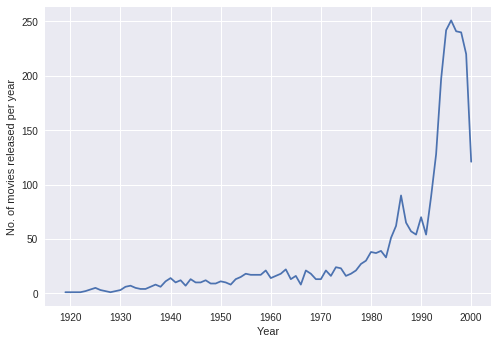

In [0]:
plt.plot(master_movies_df.groupby(by="year").movie_id.count())
plt.xlabel("Year")
plt.ylabel("No. of movies released per year")
plt.show()

There are in total 3042 unique movies and 3256 users who has rated one of the movies.
Distribution of movies shows an exponential increase starting from 1920 onwards. Most of the movies were released after 1990s.

#### Popularity of Movies by number of ratings received

In [0]:
rating_distribution = master_data.groupby("movie_name_corrected").agg({"rating":["count","min","max","mean","std"]})
rating_distribution.columns=["no_of_rating","min_rating","max_rating","mean_rating","rating_std"]
rating_distribution.sort_values(by="no_of_rating",ascending=False)

,no_of_rating,min_rating,max_rating,mean_rating,rating_std
movie_name_corrected,,,,,
American Beauty,1684,1.0,5.0,4.364608,0.956614
Star Wars: Episode V - The Empire Strikes Back,1585,1.0,5.0,4.280757,0.849860
Star Wars: Episode IV - A New Hope,1573,1.0,5.0,4.464717,0.791692
Star Wars: Episode VI - Return of the Jedi,1539,1.0,5.0,4.016894,0.925565
Back to the Future,1396,1.0,5.0,3.944842,0.862917
The Matrix,1373,1.0,5.0,4.335761,0.932962
The Sixth Sense,1369,1.0,5.0,4.418554,0.806212
The Silence of the Lambs,1360,1.0,5.0,4.352206,0.843228
Saving Private Ryan,1353,1.0,5.0,4.335551,0.859880


<div class="alert alert-block alert-info">
We rank popularity of the movies by number of ratings they received. The list shows that the most popular movie is American Beauty, followed by Star War series.
</div>

#### Popularity of Genres by count


In [0]:
# Genres count per year

genre_popularity = master_movies_df[["year","genre_label","movie_id"]]
genre_list=pd.concat([pd.Series(row["year"],
                 row["genre_label"].split(" "))
         for _, row in genre_popularity.iterrows()]).reset_index()
genre_list.columns = ["genre","year"]
genre_list['total']=1
genre_count = genre_list.groupby(by=("year","genre")).count()
genre_count=genre_count.reset_index(level=["year","genre"])

In [0]:
genre_count.sample(n=5) 

,year,genre,total
176,1949,Musical,2
85,1940,Animation,1
436,1972,Horror,1
331,1963,Animation,1
586,1984,Fantasy,4


In [0]:
total_genre_count  = genre_count.groupby(by="genre").agg({"total":"sum"}).sort_values(by="total",ascending=False)


In [0]:
total_genre_count = total_genre_count.reset_index(level="genre")

In [0]:
plt.bar(total_genre_count['genre'], total_genre_count['total'], color='g')
plt.title("Distribution of genres over the years")
plt.xlabel ("Genre")
plt.ylabel ("Count")
plt.xticks(rotation='vertical')
plt.show()

<div class="alert alert-block alert-info">
By plotting the distribution of number of ratings received by each genre over the years, we are able to visualize the change in popularity of genres over the years.
</div>

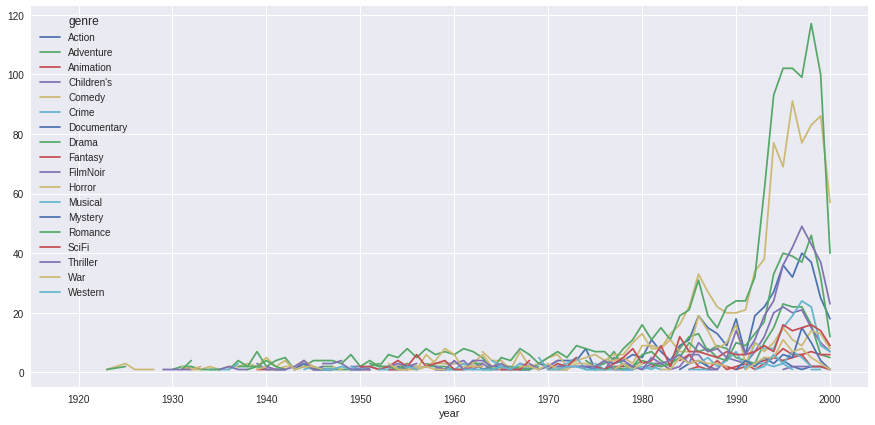

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
genre_count.groupby(by=["year","genre"]).max()['total'].unstack().plot(ax=ax)

<div class="alert alert-block alert-info">
The shape of the curve over the years is similiar for most of the genres. This suggests that time of popluarity change is about the same for all genres over the years. The graph also suggests that drama and comedy are the two most popular genres. Before 1985 and after 1990, drama movies are always more popular than comedy. However, between 1985 to 1990, both genres encountered a decreased in the popularity. In particular, drama suffers a greater loss and becomes less popular than comedy. This period may be the bottleneck for action movies.
</div>

In [0]:
genre_rating = master_data[["year","genre_label","rating"]]
genre_rating_list = pd.concat([pd.Series(row["rating"],
                 row["genre_label"].split(" "))
         for _, row in master_data.iterrows()]).reset_index()
genre_rating_list.columns=["genre","rating"]
avg_genre_rating = genre_rating_list.groupby(by="genre").agg({"rating":["count","mean","min","median","max","std"]})

In [0]:
avg_genre_rating=avg_genre_rating.reset_index(level=["genre"])
avg_genre_rating.columns=["genre","no_of_ratings","mean_rating","min_rating","median_rating","max_rating","std deviation"]
avg_genre_rating.sort_values(by="mean_rating",ascending=False)

,genre,no_of_ratings,mean_rating,min_rating,median_rating,max_rating,std deviation
9,FilmNoir,9312,4.084085,1.0,4.0,5.0,0.930697
16,War,33129,3.903166,1.0,4.0,5.0,1.065152
7,Drama,170188,3.779444,1.0,4.0,5.0,1.041967
5,Crime,40806,3.734769,1.0,4.0,5.0,1.070833
2,Animation,19463,3.707907,1.0,4.0,5.0,1.061234
12,Mystery,20449,3.704387,1.0,4.0,5.0,1.071624
6,Documentary,467,3.698073,1.0,4.0,5.0,1.164964
11,Musical,18734,3.667610,1.0,4.0,5.0,1.098210
17,Western,10248,3.646663,1.0,4.0,5.0,1.107986
13,Romance,73501,3.630400,1.0,4.0,5.0,1.063427


In [0]:
sub_df=avg_genre_rating.sort_values(by="mean_rating",ascending=False)[['genre','mean_rating']]

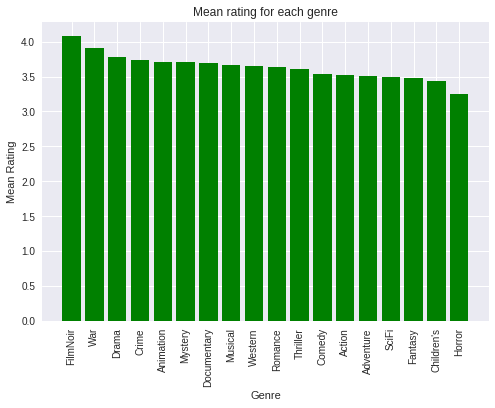

In [0]:
plt.bar(sub_df['genre'], sub_df['mean_rating'], color='g')
plt.title("Mean rating for each genre")
plt.xlabel ("Genre")
plt.ylabel ("Mean Rating")
plt.xticks(rotation='vertical')
plt.show()

<div class="alert alert-block alert-info">
Among all movie genres, *Film-Noir* movies have the highest mean rating and *Horror* movies receive the lowest. This suggests that audiences who have watched filmnoir generally enjoy the movie and consistent with high ratings. This may also suggests that there is a distinct prefercence group for filmnoir. Horror films on the other hand are less preferred. 
<br><br>
One thing to note is that both *Film-Noir* and *Horror* lie at the lower end of popularity distribution. Difference in the ratings shows distinct different preferences towards non-mainstream movies. Mean ratings for popular genres such as action and comedy are rather netural which align with the popularity received.
</div>

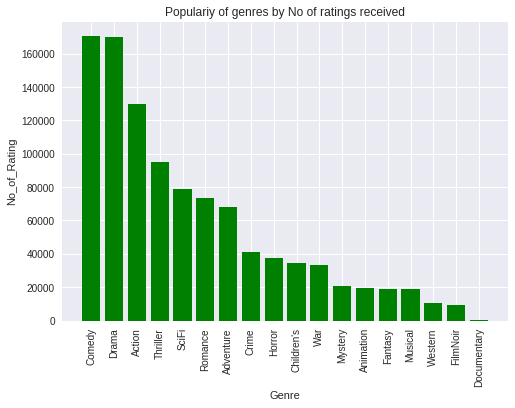

In [0]:
sub_df2=avg_genre_rating.sort_values(by="no_of_ratings",ascending=False)[['genre','no_of_ratings']]
plt.bar(sub_df2['genre'], sub_df2['no_of_ratings'], color='g')
plt.title("Populariy of genres by No of ratings received")
plt.xlabel ("Genre")
plt.ylabel ("No_of_Rating")
plt.xticks(rotation='vertical')
plt.show()


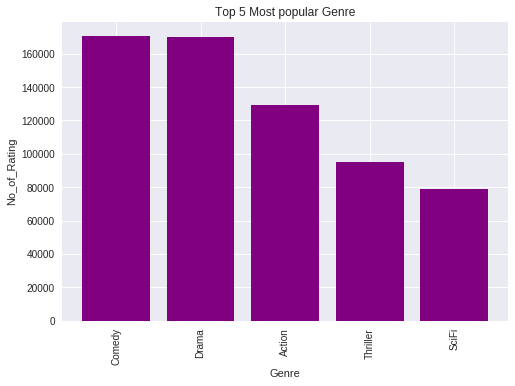

In [0]:
plt.bar(sub_df2['genre'][0:5], sub_df2['no_of_ratings'][0:5], color='purple')
plt.title("Top 5 Most popular Genre")
plt.xlabel ("Genre")
plt.ylabel ("No_of_Rating")
plt.xticks(rotation='vertical')
plt.show()


<div class="alert alert-block alert-info">
The above 2 charts shows the genres that received the most number of ratings. The top 5 most popular genres are <code>Comedy</code>, <code>Drama</code>, <code>Action</code>, <code>Thriller</code> and <code>Sci-Fi</code>. Over here, we can see that the most rated genres are not the same as genres that have the highest average ratings. This implies that there is no correlation between number of ratings received and the magnitude of the ratings received. 
</div>

#### Distribution of genres among the Best rated movies (Rating-5) and Worst rated movies (Rating-1)

In [0]:
master_cast_lst=[]
for i in master_data.Cast_clean:
    if pd.isnull(i)==False:
        for x in i.split(","):
              if x!=" Narrated by" and x!=" Jr.":
                master_cast_lst.append(x)
master_cast_top5=Counter(master_cast_lst).most_common(5)
##top 5 most frequent Genre in movie_info
master_genre_lst=[]
for i in master_data.genre_label:
    if pd.isnull(i)==False:
        master_genre_lst.extend(i.split(" "))
master_genre_top5=Counter(master_genre_lst).most_common(5)

In [0]:
# top 5 cast in movies of ratings 5.0
five_cast_lst=[]
five_movies = master_data.loc[master_data['rating'] == 5]
for i in five_movies.Cast_clean:
      if pd.isnull(i)==False:
        five_cast_lst.extend(i.split(","))
five_cast_top5=Counter(five_cast_lst).most_common(5)

# top 5 genres in movies of ratings 5.0
five_genre_lst=[]
for i in five_movies.genre_label:
      if pd.isnull(i)==False:
        five_genre_lst.extend(i.split(" "))
five_genre_top5=Counter(five_genre_lst).most_common(5)

# top 5 cast in movies of ratings 1.0
one_cast_lst=[]
one_movies = master_data.loc[master_data['rating'] == 1]
for i in one_movies.Cast_clean:
      if pd.isnull(i)==False:
        one_cast_lst.extend(i.split(","))
one_cast_top5=Counter(one_cast_lst).most_common(5)

# top 5 genres in movies of ratings 1.0
one_genre_lst=[]
for i in one_movies.genre_label:
      if pd.isnull(i)==False:
        one_genre_lst.extend(i.split(" "))
one_genre_top5=Counter(one_genre_lst).most_common(5)

In [0]:
genre_count_one=Counter(one_genre_lst)
master_genre_count=Counter(master_genre_lst)
unique_genre_one=set(one_genre_lst)
one_star_genre_ratio_lst={}
for i in unique_genre_one:
    one_star_genre_ratio_lst[i]=genre_count_one[i]/master_genre_count[i]
genre_ratio_pd_one_star=pd.DataFrame.from_dict(one_star_genre_ratio_lst,orient='index')
genre_ratio_pd_one_star.columns = ["One Star Ratio"]


In [0]:
genre_count_five = Counter(five_genre_lst)
unique_genre_five=set(five_genre_lst)
five_star_genre_ratio_lst={}
for i in unique_genre_one:
    five_star_genre_ratio_lst[i]=genre_count_five[i]/master_genre_count[i]
genre_ratio_pd_five_star=pd.DataFrame.from_dict(five_star_genre_ratio_lst,orient='index')
genre_ratio_pd_five_star.columns = ["Five Star Ratio"]


In [0]:
genre_ratio_pd_one_star=genre_ratio_pd_one_star.sort_values(by="One Star Ratio",ascending=False)
genre_ratio_pd_one_star

,One Star Ratio
Horror,0.111014
Children's,0.076759
Documentary,0.066381
SciFi,0.066248
Action,0.061881
Adventure,0.060423
Fantasy,0.059904
Comedy,0.059840
Western,0.052596
Thriller,0.049867


In [0]:
genre_ratio_pd_five_star=genre_ratio_pd_five_star.sort_values(by="Five Star Ratio",ascending=False)
genre_ratio_pd_five_star

,Five Star Ratio
FilmNoir,0.391860
War,0.346413
Documentary,0.295503
Drama,0.278134
Crime,0.271270
Mystery,0.258937
Musical,0.252909
Animation,0.251965
Western,0.248341
Thriller,0.229187


In [0]:
# Combine the two ratio df
pd.concat([genre_ratio_pd_one_star,genre_ratio_pd_five_star], axis=1)

,One Star Ratio,Five Star Ratio
Action,0.061881,0.209781
Adventure,0.060423,0.205786
Animation,0.041926,0.251965
Children's,0.076759,0.191503
Comedy,0.059840,0.214030
Crime,0.038130,0.271270
Documentary,0.066381,0.295503
Drama,0.032910,0.278134
Fantasy,0.059904,0.196326
FilmNoir,0.014175,0.391860


> Distribution of ratings in film-noir and horror









In [0]:
noir_distr=genre_rating_list[genre_rating_list.genre=="Film-Noir"].groupby(by="rating").count().reset_index(level="rating")

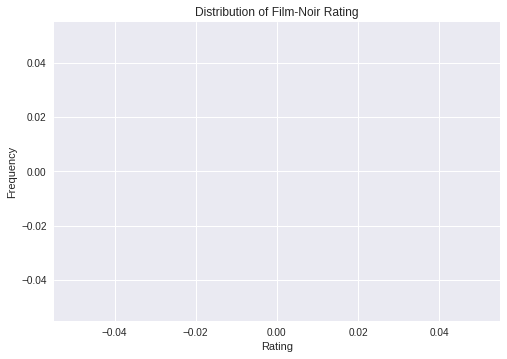

In [0]:
plt.bar(noir_distr['rating'], noir_distr['genre'], color='purple')
plt.title("Distribution of Film-Noir Rating")
plt.xlabel ("Rating")
plt.ylabel ("Frequency")
plt.xticks(rotation=0)
plt.show()

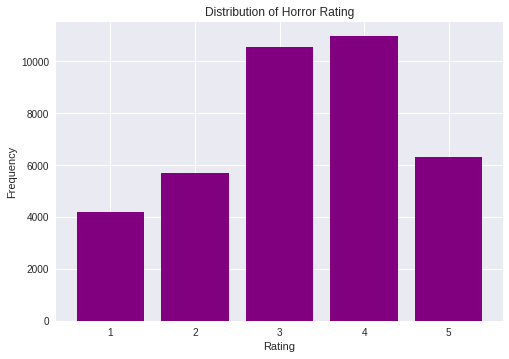

In [0]:
horr_distr=genre_rating_list[genre_rating_list.genre=="Horror"].groupby(by="rating").count().reset_index(level="rating")
plt.bar(horr_distr['rating'], horr_distr['genre'], color='purple')
plt.title("Distribution of Horror Rating")
plt.xlabel ("Rating")
plt.ylabel ("Frequency")
plt.xticks(rotation=0)
plt.show()

<div class="alert alert-block alert-info">
The 2 charts shows the distribution of ratings for our best rated genre (Film-Noir) and worst rated genre (Horror). We can see that most ratings for Film-Noir are of rating-4 and rating-5, while there is a significantly higher proportion of rating-1 and rating-2 compared with Film-Noir. By calculating the ratio of ratings appearing in both five star and one star, it gives a more accurate measure of the movie prefercences.
The results align with the mean rating presented in part2
</div>

### Distribution of Cast over the years

In this section, number of cast 

In [0]:
cast_popularity = master_movies_df[["year","Cast_clean","movie_id"]]
cast_list=pd.concat([pd.Series(row["year"],
                 row["Cast_clean"].split(" "))
         for _, row in cast_popularity.iterrows()]).reset_index()
cast_list.columns = ["Cast_clean","year"]
cast_list['total']=1
cast_count = cast_list.groupby(by=("year","Cast_clean")).count()
cast_count=cast_count.reset_index(level=["year","Cast_clean"])

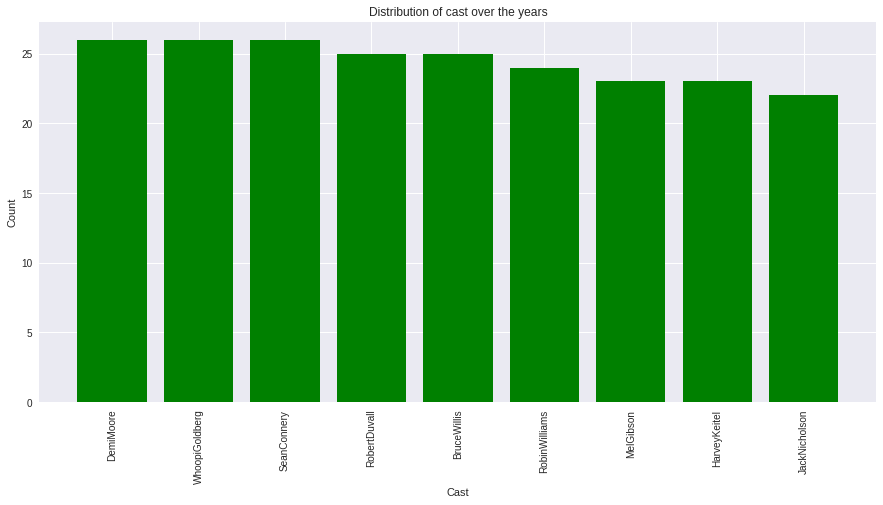

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
total_cast_count = cast_count.groupby(by="Cast_clean").agg({"total":"sum"}).sort_values(by="total",ascending=False)
total_cast_count.reset_index(level="Cast_clean",inplace=True)
total_cast_count = total_cast_count.iloc[3:,]
plt.bar(total_cast_count['Cast_clean'].iloc[1:10,], total_cast_count['total'].iloc[1:10,], color='g')
plt.title("Distribution of cast over the years")
plt.xlabel ("Cast")
plt.ylabel ("Count")
plt.xticks(rotation = 'vertical')
plt.show()                                                                                    

<div class="alert alert-block alert-info">
The above chart shows the top casts ranked by number of apperances in the master move dataset. Most of the cast are either comedians or action actors/actress. This aligns with the previous finding  which popular movie genres are action movies or comedies.
</div>

### Popularity of Cast by number of ratings received

In [0]:
cast_rating = master_data[["year","Cast_clean","rating"]]
cast_rating_list = pd.concat([pd.Series(row["rating"],
                 row["Cast_clean"].split(" "))
         for _, row in master_data.iterrows()]).reset_index()
cast_rating_list.columns=["Cast_clean","rating"]
avg_cast_rating = cast_rating_list.groupby(by="Cast_clean").agg({"rating":["count","mean","min","median","max","std"]})

In [0]:
avg_cast_rating=avg_cast_rating.reset_index(level=["Cast_clean"])
avg_cast_rating.columns=["Cast_clean","no_of_ratings","mean_rating","min_rating","median_rating","max_rating","std deviation"]
avg_cast_rating.sort_values(by="no_of_ratings",ascending=False)

,Cast_clean,no_of_ratings,mean_rating,min_rating,median_rating,max_rating,std deviation
1805,HarrisonFord,13818,4.058474,1.0,4.0,5.0,0.935758
4050,RobertDeNiro,9749,3.859986,1.0,4.0,5.0,1.002146
4649,TomHanks,9577,3.911768,1.0,4.0,5.0,0.986989
3316,MelGibson,8805,3.634185,1.0,4.0,5.0,1.035748
623,BruceWillis,8554,3.754384,1.0,4.0,5.0,1.119900
4304,SeanConnery,7820,3.747442,1.0,4.0,5.0,1.002759
1631,GeneHackman,7777,3.660023,1.0,4.0,5.0,1.003921
2766,KevinSpacey,7372,4.066061,1.0,4.0,5.0,0.979288
328,ArnoldSchwarzenegger,7054,3.571874,1.0,4.0,5.0,1.105845
486,BillMurray,6886,3.643480,1.0,4.0,5.0,1.055589


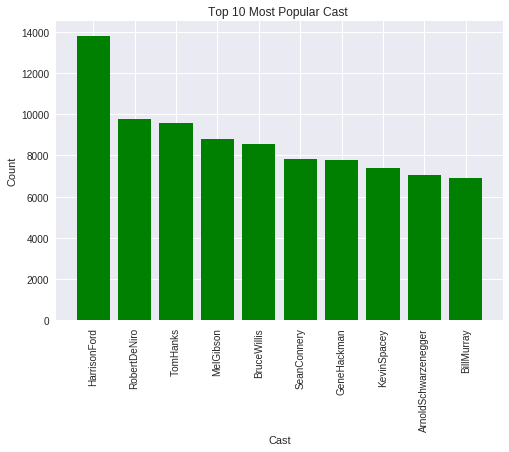

In [0]:
popular_cast=avg_cast_rating.sort_values(by="no_of_ratings",ascending=False)

plt.bar(popular_cast['Cast_clean'].iloc[0:10,], popular_cast['no_of_ratings'].iloc[0:10,], color='g')
plt.title("Top 10 Most Popular Cast ")
plt.xlabel ("Cast")
plt.ylabel ("Count")
plt.xticks(rotation = 'vertical')
plt.show()

<div class="alert alert-block alert-info">
The above chart shows the casts in movies that received the most number of ratings. We can see that these casts are mostly different from the previous list of cast. This list of casts are more likely to be from drama and comedy movies. 
</div>

### Distribution of directors over the years

In [0]:
# director_rating = master_data[["year","Director_clean","rating"]]
director_rating_list = pd.concat([pd.Series(row["rating"],
                 row["Director_clean"].split(" "))
         for _, row in master_data.iterrows()]).reset_index()
director_rating_list.columns=["Director_clean","rating"]
avg_director_rating = director_rating_list.groupby(by="Director_clean").agg({"rating":["count","mean","min","median","max","std"]})
avg_director_rating=avg_director_rating.reset_index(level=["Director_clean"])
avg_director_rating.columns=["Director_clean","no_of_ratings","mean_rating","min_rating","median_rating","max_rating","std deviation"]
avg_director_rating.sort_values(by="no_of_ratings",ascending=False)

,Director_clean,no_of_ratings,mean_rating,min_rating,median_rating,max_rating,std deviation
1448,StevenSpielberg,10871,4.016558,1.0,4.0,5.0,0.991640
1317,RobertZemeckis,6445,3.703026,1.0,4.0,5.0,1.005848
662,JamesCameron,5831,3.905677,1.0,4.0,5.0,0.980087
1279,RobReiner,5242,4.054750,1.0,4.0,5.0,0.916811
1246,RichardDonner,5016,3.559809,1.0,4.0,5.0,0.985038
69,AlfredHitchcock,5015,4.149751,1.0,4.0,5.0,0.864185
1490,TimBurton,4847,3.404993,1.0,4.0,5.0,1.060490
1407,StanleyKubrick,4519,4.072804,1.0,4.0,5.0,1.047674
1272,RidleyScott,4315,3.983082,1.0,4.0,5.0,1.002519
456,FrancisFordCoppola,4286,4.063696,1.0,4.0,5.0,1.031093


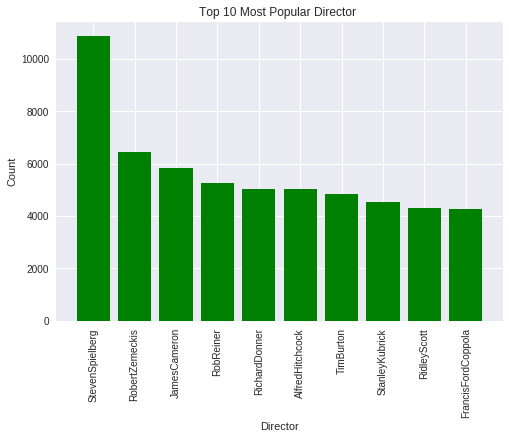

In [0]:
popular_director=avg_director_rating.sort_values(by="no_of_ratings",ascending=False)

plt.bar(popular_director['Director_clean'].iloc[0:10,], popular_director['no_of_ratings'].iloc[0:10,], color='g')
plt.title("Top 10 Most Popular Director ")
plt.xlabel ("Director")
plt.ylabel ("Count")
plt.xticks(rotation = 'vertical')
plt.show()

<div class="alert alert-block alert-info">
The chart above shows the most popular directors based on the number of ratings a movie received. We see a significant number of ratings go towards movies directed by *Steven Spielberg*. This might imply that directors who have a long history in making movies would thus be very experienced. This results in a higher proportion of well directed movies. However, we cannot conclude that movies directed a certain director is more likely to be well rated by audiences.
</div>

#### Top 5 frequent genres of movies and casts
*Casts are ranked based on the number of movies he/she has acted in*

In [0]:
cast_lst=[]
for i in master_movies_df.Cast:
      if pd.isnull(i)==False:
        for x in i.split(","):
              if x!=" Narrated by" and x!=" Jr.":
                    cast_lst.append(x)
cast_top5=Counter(cast_lst).most_common(5)

#top 5 most frequent Genre in movie_info
genre_lst=[]
for i in master_movies_df.genre_label:
      if pd.isnull(i)==False:
        genre_lst.extend(i.split(" "))
genre_top5=Counter(genre_lst).most_common(5)

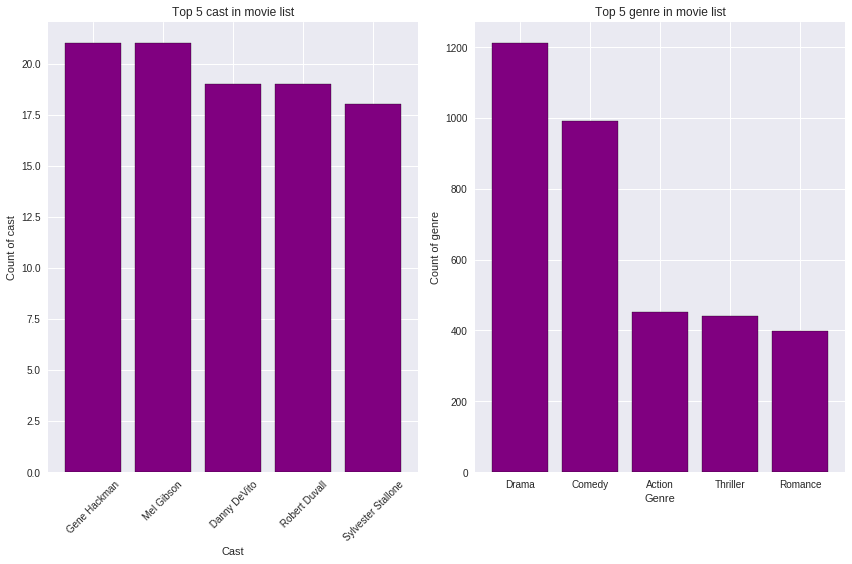

In [0]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,2)
plt.bar(x=[g[0] for g in genre_top5], height=[g[1] for g in genre_top5], color="purple", edgecolor="black")
plt.title("Top 5 genre in movie list")
plt.xlabel ("Genre")
plt.ylabel ("Count of genre")

plt.subplot(1,2,1)
plt.bar(x=[g[0] for g in cast_top5], height=[g[1] for g in cast_top5], color="purple", edgecolor="black")
plt.title("Top 5 cast in movie list")
plt.xticks(rotation=45)
plt.xlabel ("Cast")
plt.ylabel ("Count of cast")

plt.tight_layout()
plt.show()

#### Top 5 watched genres and casts among Best rated movies (Rating-5)

In [0]:
# top 5 cast in movies of ratings 5.0
five_cast_lst=[]
five_movies = master_data.loc[master_data['rating'] == 5]
for i in five_movies.Cast_clean:
      if pd.isnull(i)==False:
        five_cast_lst.extend(i.split(" "))
five_cast_top5=Counter(five_cast_lst).most_common(5)

# top 5 genres in movies of ratings 5.0
five_genre_lst=[]
for i in five_movies.genre_label:
      if pd.isnull(i)==False:
        five_genre_lst.extend(i.split(" "))
five_genre_top5=Counter(five_genre_lst).most_common(5)

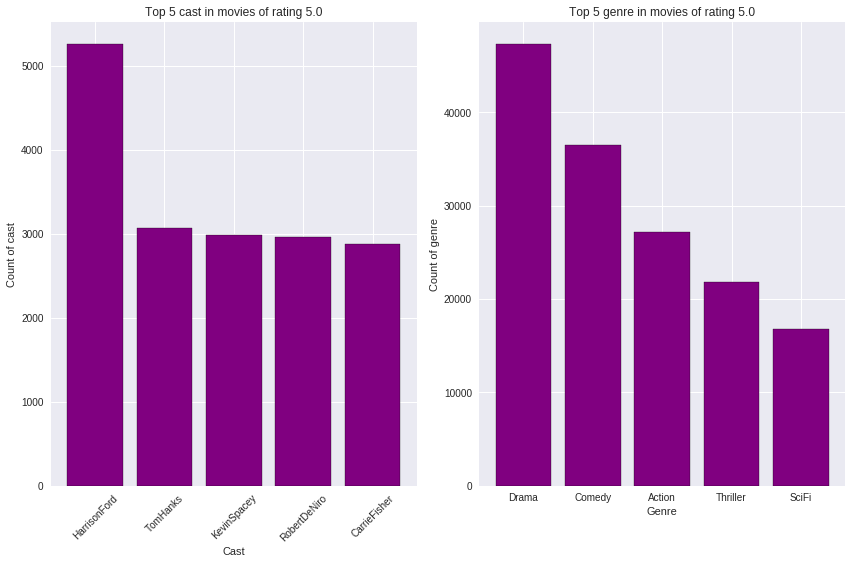

In [0]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.bar(x=[g[0] for g in five_cast_top5], height=[g[1] for g in five_cast_top5], color="purple", edgecolor="black")
plt.title("Top 5 cast in movies of rating 5.0")
plt.xticks(rotation=45)
plt.xlabel ("Cast")
plt.ylabel ("Count of cast")

plt.subplot(1,2,2)
plt.bar(x=[g[0] for g in five_genre_top5], height=[g[1] for g in five_genre_top5], color="purple", edgecolor="black")
plt.title("Top 5 genre in movies of rating 5.0")
plt.xlabel ("Genre")
plt.ylabel ("Count of genre")
plt.tight_layout()
plt.show()

#### Top 5 watched genres and casts among Worst rated movies (Rating-1)

In [0]:
# top 5 cast in movies of ratings 1.0
one_cast_lst=[]
one_movies = master_data.loc[master_data['rating'] == 1]
for i in one_movies.Cast_clean:
      if pd.isnull(i)==False:
        one_cast_lst.extend(i.split(" "))
one_cast_top5=Counter(one_cast_lst).most_common(5)

# top 5 genres in movies of ratings 1.0
one_genre_lst=[]
for i in one_movies.genre_label:
      if pd.isnull(i)==False:
        one_genre_lst.extend(i.split(" "))
one_genre_top5=Counter(one_genre_lst).most_common(5)

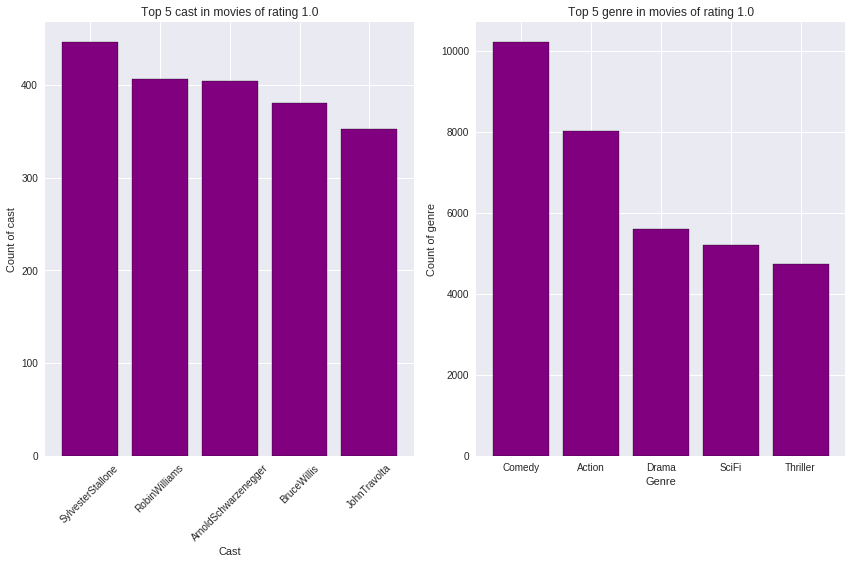

In [0]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.bar(x=[g[0] for g in one_cast_top5], height=[g[1] for g in one_cast_top5], color="purple", edgecolor="black")
plt.title("Top 5 cast in movies of rating 1.0")
plt.xticks(rotation=45)
plt.xlabel ("Cast")
plt.ylabel ("Count of cast")

plt.subplot(1,2,2)
plt.bar(x=[g[0] for g in one_genre_top5], height=[g[1] for g in one_genre_top5], color="purple", edgecolor="black")
plt.title("Top 5 genre in movies of rating 1.0")
plt.xlabel ("Genre")
plt.ylabel ("Count of genre")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    The top 5 genres for both Best rated movies and Worst rated movies are extremely similar, with *Comedy*, *Action* and *Drama* taking the top 3 spots. The only difference we see is the ranking of the genres. In the Best rated movies, *Drama* movies are rated the best while *Comedy* movies are rated the worst. On the other hand, the top 5 casts for both type of ratings are different from each other. We can also see that they are mostly comedians or action stars which aligns with popularity of genres in the respective ratings.
</div>

#### Distributions of ratings among various demographic groups

We would like to have a closer look at the best rated and worst rated movies.

In [0]:
def groupby_result(col):
    d=master_data.groupby(['rating',col]).count()
    g=d['movie_id'].groupby(level=0,group_keys=False)
    res=g.apply(lambda x:x.sort_values(ascending=False).head(3))
    return res

def plot(series, ind, col, val):
    df = series.to_frame().reset_index()
    df.pivot(index=ind, columns=col, values=val).plot(kind='bar', figsize=(8,8))

##### Age vs Ratings

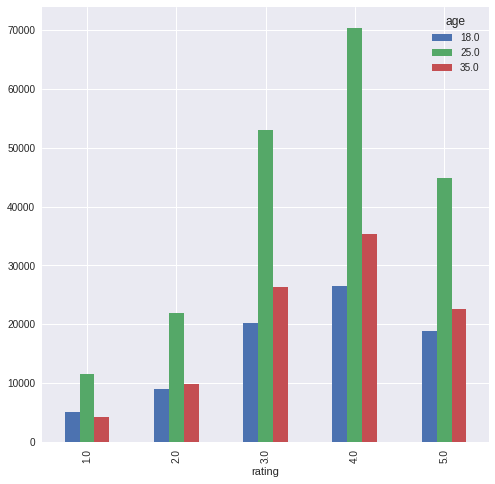

In [0]:
plot(groupby_result('age'), 'rating', 'age', 'movie_id')

<div class="alert alert-block alert-info">
As we have multiple age groups, we chose to see what are the distributions of ratings for the top 3 occupations. The top 3 age groups are considered to be young to middle age working adults. While the top 3 age groups show different distribution of ratings, the overall distribution are similar for each rating type. They are less likely to give bad ratings of 1 to 2 stars, and more likely to give good ratings of 4 stars.
</div>

##### Occupations vs Ratings

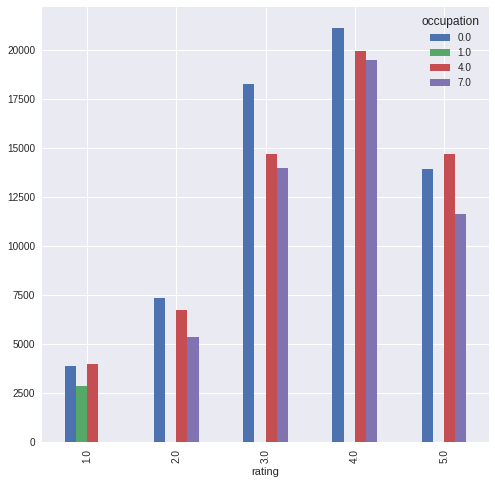

In [0]:
plot(groupby_result('occupation'), 'rating', 'occupation', 'movie_id')

<div class="alert alert-block alert-info">
    Due to the large number of occupations, we chose to analyse the most common occupations. We can see that a large portion of each occupation tends to give neutral to good ratings of 3 to 5 stars. However when we break it down, we see that Executives (occupation 7) is less likely to give bad ratings of 1 star while Educators (occupation 1) is more likely to give bad ratings of 1 star. Colleage students (occupation 4) has a significantly higher number of 5 star ratings compared with Executives. These differences in distribution of ratings among different occupation groups suggests there is correlation between occupation and ratings.  
</div>

##### Gender vs Ratings

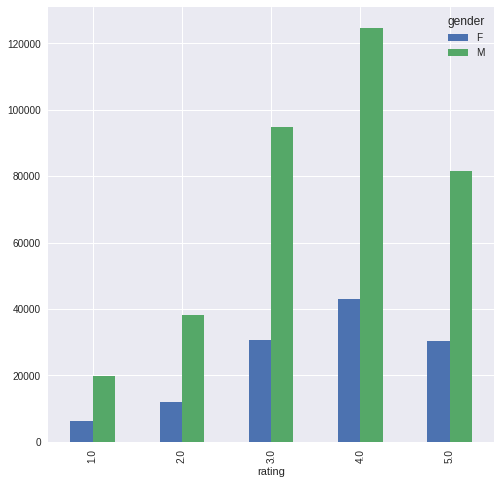

In [0]:
plot(groupby_result('gender'), 'rating', 'gender', 'movie_id')

<div class="alert alert-block alert-info">
    The overall distribution of ratings among gender is generally the same as the population, with both gender types more likely to give neutral to good ratings of 3 to 5 stars. The breakdown of the distribution shows the population is skewed towards the *Males* which may imply that male audiences are more active in rating/watching movies. 
</div>

##### Residential Region vs Ratings

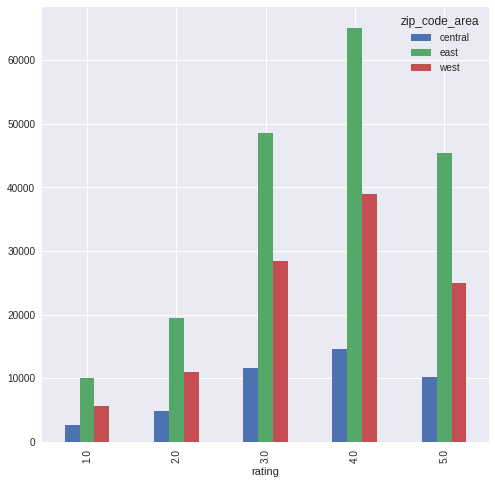

In [0]:
plot(groupby_result('zip_code_area'),'rating','zip_code_area','movie_id')

<div class="alert alert-block alert-info">
    
</div>

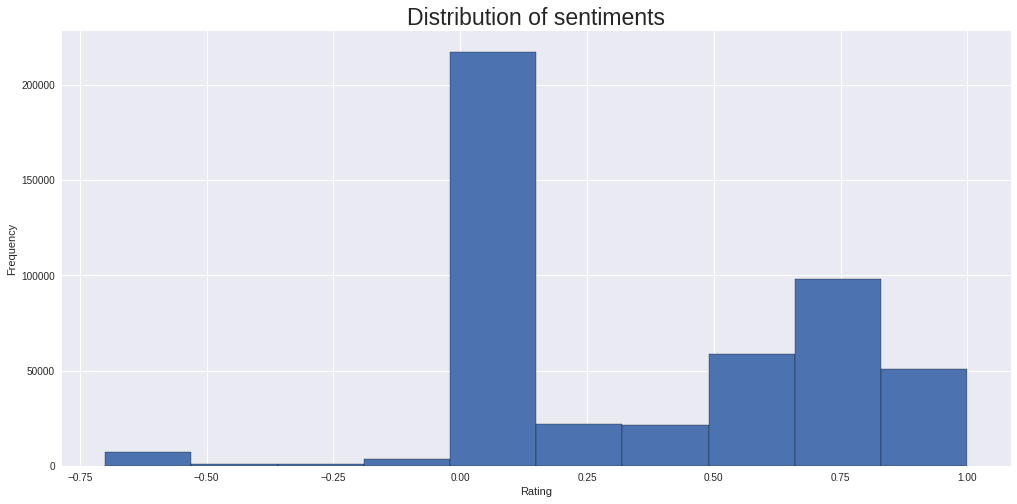

In [0]:
master_data['sentiment'].hist(bins=10, figsize=(17,8), edgecolor="black")
plt.title("Distribution of sentiments", fontsize=23)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

<div class="alert alert-block alert-info">
    Although the distribution shows most of the movie tags are neutral, a substaintial number of tags are of a more positive sentiment (0.5 to 1.0). This distribution explains why most of the ratings are between 3 to 5 stars. 
</div>

##### Sentiments vs Ratings

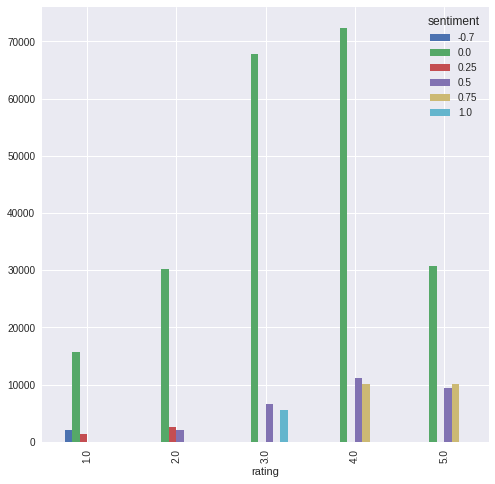

In [0]:
plot(groupby_result('sentiment'), 'rating', 'sentiment', 'movie_id')

<div class="alert alert-block alert-info">
    Following the histogram results, the distribution of ratings among the different sentiment values shows a large proportion of neutral sentiment (0.0) occupies each ratings and this distribution follows that of the population distribution of ratings. We also do not see any negative sentiments in the good ratings which is logical. In general, as the ratings becomes better (increasing from 1 to 5), the number of more positive sentiments also increases. One interesting thing to note is that the most positive sentiments (1.0) only appears in the neutral rating (3 stars). This suggests that audience may prefer more conflicted plots which tends to be more excitng and breathtaking than neutral plots which can be dull sometimes.
</div>



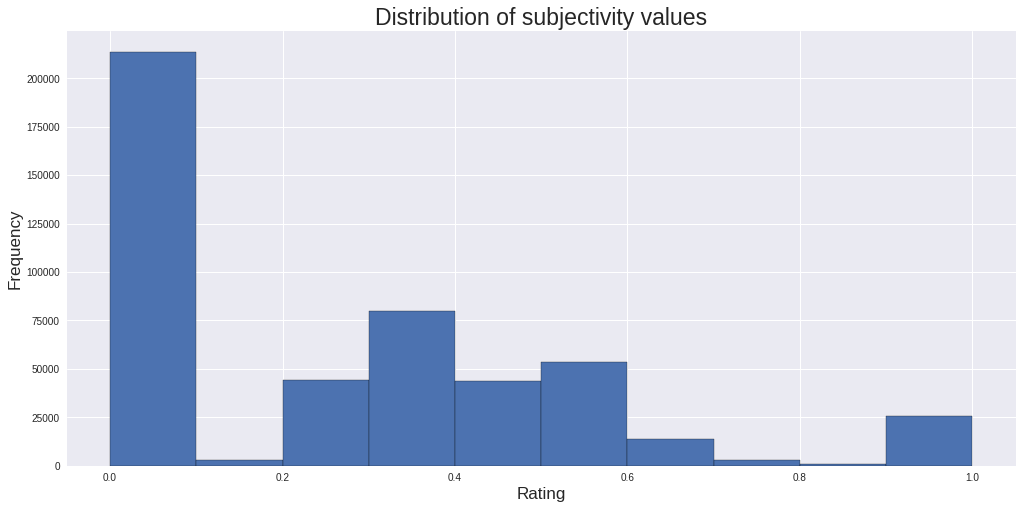

In [0]:
master_data['subjectivity'].hist(bins=10, figsize=(17,8), edgecolor="black")
plt.title("Distribution of subjectivity values", fontsize=23)
plt.xlabel("Rating", fontsize=17)
plt.ylabel("Frequency", fontsize=17)
plt.show()

<div class="alert alert-block alert-info">
    Majority of the movies have subjectivty scores of 0 which suggest that the tags used to describe them are do not express an opinion of the movie. However, we do see a sizable number of movies that have subjectivity scores of 0.4 to 0.6. These movies with such tags may have some insights into what audiences think of the movie. However, we cannot conclude that these opinions expresses any sentiment values.  
</div>





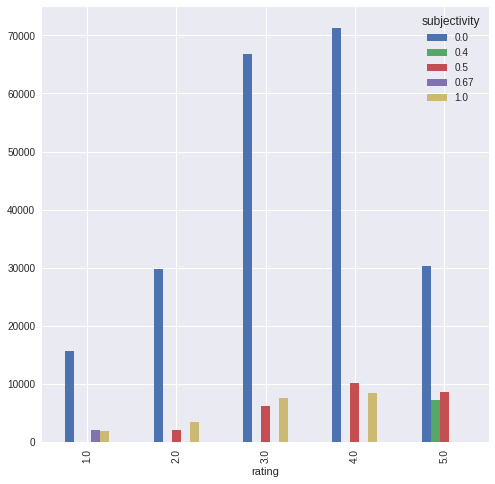

In [0]:
plot(groupby_result('subjectivity'), 'rating', 'subjectivity', 'movie_id')

<div class="alert alert-block alert-info">
    From the distributions, we observe that a large portion of movies with objective tags have a rating of 3 to 4 stars. On the other hand, movies in the five star ratings have lower subjectivity scores, suggesting that audiences may prefer less subjective movies.
</div>

### 3.1 Distribution of User Demographics

#### Ratings

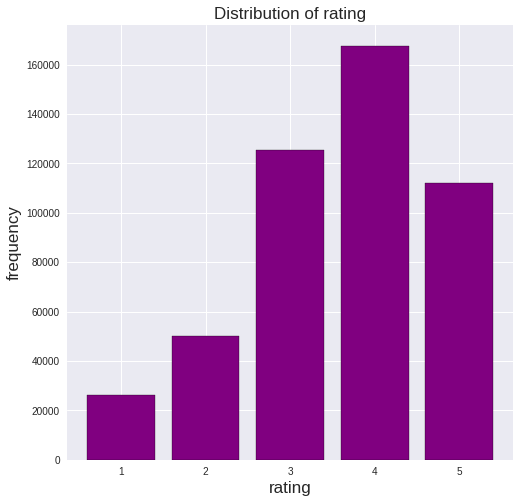

In [0]:
def distribution(col):
    freq_count = dict(master_data.groupby(col).count()['movie_id'])
    plt.figure(figsize=(8,8))
    plt.bar(freq_count.keys(), freq_count.values(), color="purple", edgecolor="black")
    plt.title("Distribution of %s"%col, fontsize=17)
    plt.xlabel(col, fontsize=17)
    plt.ylabel("frequency", fontsize=17)

distribution("rating")

The distribution of rating follows a bell shape. Audience tend to give median ratings (3~4) more frequently than extremely low or extremely high ratings. Number of 1 star ratings is the least. This may suggest that audiences tend to choose watch movies that match their preferences and interests only. It is unlikely for audiences to step out of the "comfort zone" and watch movies when there is a mismatch of interest. Hence it is important to separate audiences based on their prefereneces and identify commonalities within the group.

#### Occupations

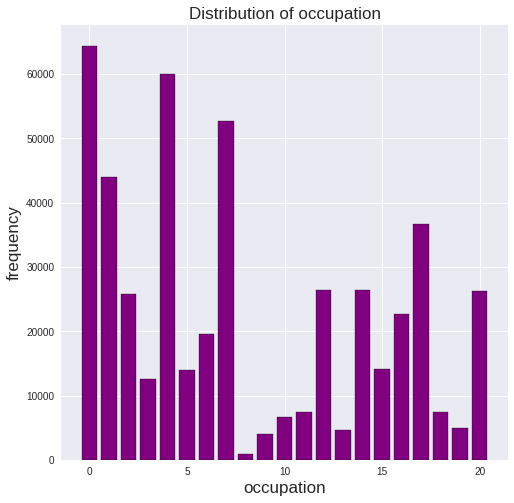

In [0]:
distribution("occupation")

<div class="alert alert-block alert-info">
The distribution shows the most audiences are *Educator (occupation 1)*, *College Student (occupation 4)*, *Executive (occupation 7)* and *Engineer (occupation 17)*. The occupation with the least number of audience is *Farmer (occupation 8)* which is explanatory as they tend to live in the country sides which generally do not have access to cinemas. We can also see that a large portion of audience did not specify their occupation (occupation 0). However, we will not exlcude them as they may have other details which maybe useful in the analysis later on.
</div>

#### Age

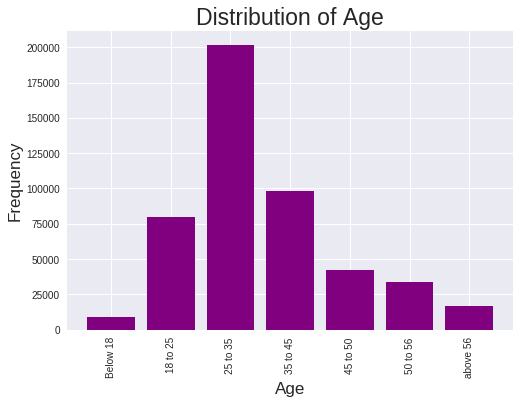

In [0]:
sub_df2=master_data[['age','movie_id']].groupby(by="age").count()
sub_df=sub_df2.reset_index(level="age")
sub_df['age']=["Below 18","18 to 25","25 to 35","35 to 45","45 to 50","50 to 56","above 56"]
plt.bar(sub_df['age'], sub_df['movie_id'], color='purple')
plt.title("Distribution of Age", fontsize=23)
plt.xlabel ("Age", fontsize=17)
plt.ylabel ("Frequency", fontsize=17)
plt.xticks(rotation='vertical')
plt.show()

<div class="alert alert-block alert-info">
A large proportion of the audience are from the age groups *18 to 25*, *25 to 35* and *35 to 45*, with a significantly large portion from age group 25 to 35. One reason could be they are earning an income and are considered young adults. As such, they will have the time to hang out with friends after their work and go watch movies together. 
</div>

#### Residential Region

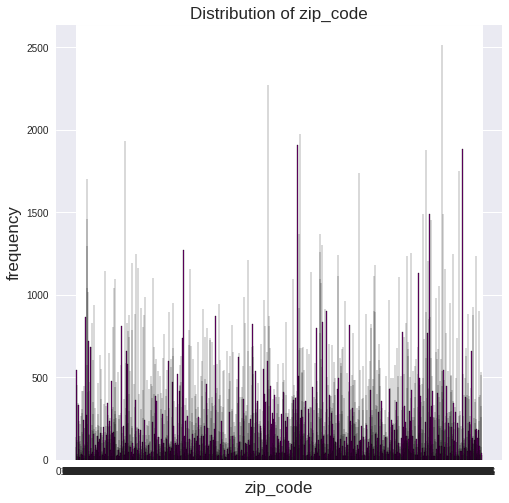

In [0]:
distribution("zip_code")

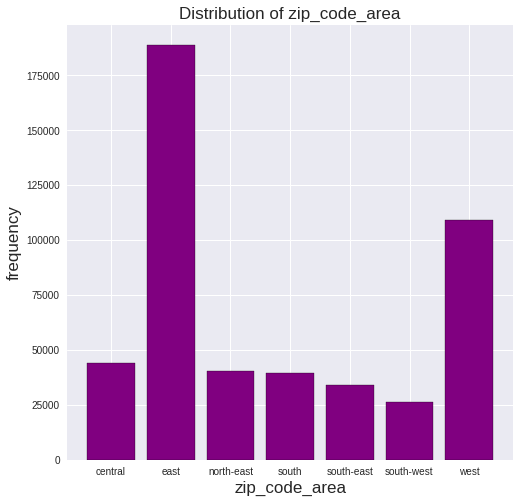

In [0]:
distribution("zip_code_area")

<div class="alert alert-block alert-info">
A significantly large number of audience resides in the *East* region. This is followed by *West* region. This would imply that the East and West regions are more active in rating the movies compared to other regions. The other regions are relatively evenly distributed except for South-West. 
</div>

#### Frequency of number of ratings given per audience/movie

In [0]:
def distribution(col):
    freq_dict = dict(master_data[col].value_counts())
    freq_count=dict(Counter(freq_dict.values()).most_common())
    plt.bar(freq_count.keys(), freq_count.values(), color="purple")
    plt.title("Distribution of %s"%col, fontsize=20)
    plt.ylabel("Frequency", fontsize=17)
    plt.xlabel(col, fontsize=17)

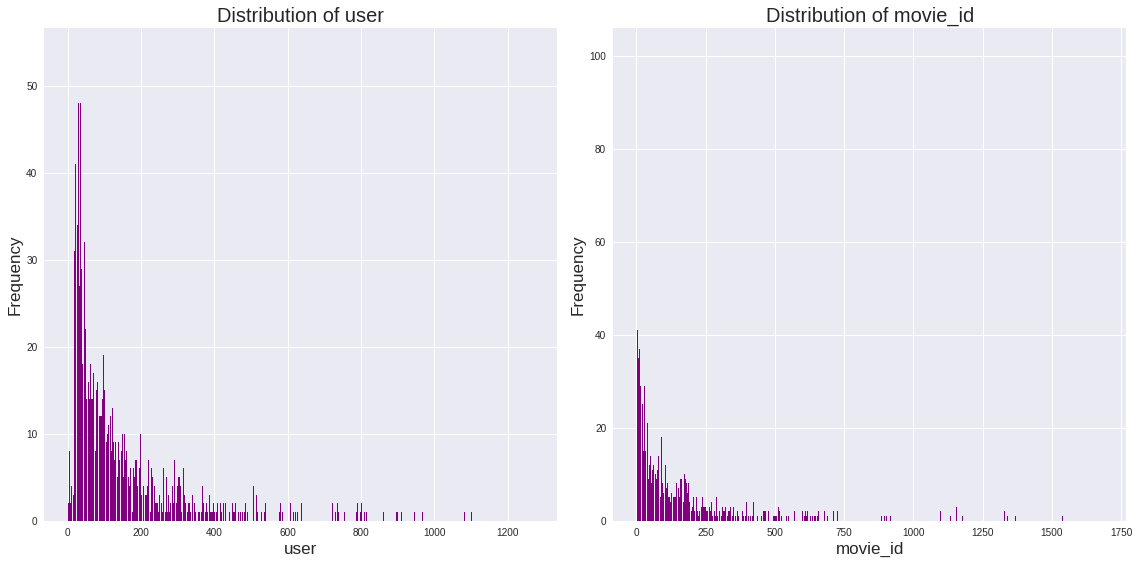

In [0]:
## Distribution of users and movies
plt.figure(figsize=(16,8))

# plot number of users vs total ratings given
plt.subplot(1,2,1)
distribution("user")

# plot number of movies vs total ratings received
plt.subplot(1,2,2)
distribution("movie_id")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
The chart on the left shows the distribution of number of ratings given per audience, suggests that majority of the audience gives less than 10 ratings. This ensures the variety of ratings received from different audiences, reducing the biases in the rating dataset. 
</div>
<br>
<div class="alert alert-block alert-info">
The 2nd chart on the right shows the distribution of number of ratings received by movies follows a similiar pattern of the 1st chart. This will suggest there are only a few movies that have high popularity and many movies with a similiar popularities.
</div>

### 3.2 Distribution of genres among demographic groups

In [0]:
master_data['genres'] = master_data['genre_label'].apply(lambda label: label.split(" "))

In [0]:
def demo_genre_distribution(demo):
    demo_groups = list(master_data[demo].unique())[:-1]
    demo_genre_dict = {}
    for d in demo_groups:
        if d not in demo_genre_dict.keys():
            demo_genre_dict[d] = {}
            
    for i in range(len(master_data.index)):
        group = master_data.iloc[i][demo]
        if str(group) !='nan':
            for g in master_data.iloc[i]['genres']:
                if g not in demo_genre_dict[group].keys():
                    demo_genre_dict[group][g]=0
                else:
                    demo_genre_dict[group][g]+=1
            
    for demo_group in demo_genre_dict.keys():
        plt.bar(list(demo_genre_dict[demo_group].keys()), demo_genre_dict[demo_group].values(), color='g')
        plt.title("Distribution of genres for %s group" % (str(demo)+" "+str(demo_group)))
        plt.xlabel ("Genre")
        plt.ylabel ("Count of genre")
        plt.xticks(rotation='vertical')
        plt.show()

##### Gender vs Genres

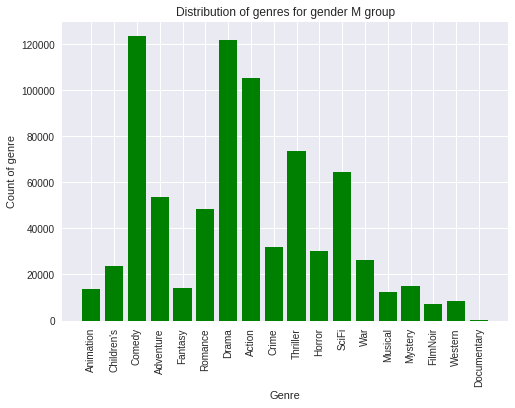

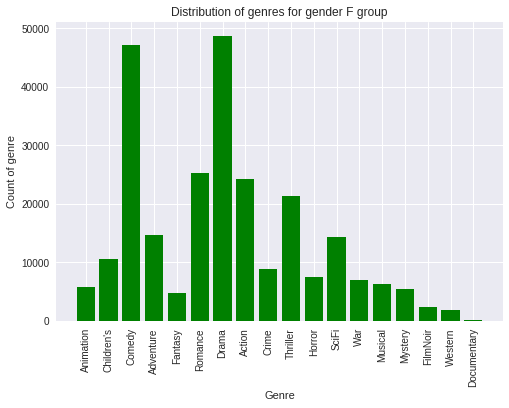

In [0]:
demo_genre_distribution('gender')

<div class="alert alert-block alert-info">
    The overall distribution trend of genres between each gender is quite similar, with the top few genres being *Drama*, *Comedy*, *Action*. However on closer inspection, we see there are minor differences between them. Here are a few differences between each gender. 
    <ul>
        <li>Most males watch Comedies while most females watch Dramas.</li>
        <li>The number of Action movies is significantly higher than females.</li>
        <li>More females watch Romance and Musical movies compared to males.</li>
    </ul>
    
    These differences highlights the preferences of both genders. Overall, males tend to watch fast paced action and funny movies while females tend to watch movies with romance with a mix of musical element inside. This lead us to think that there might be a correlation between genders and audience preferences of genres.
</div>

##### Age vs Genres

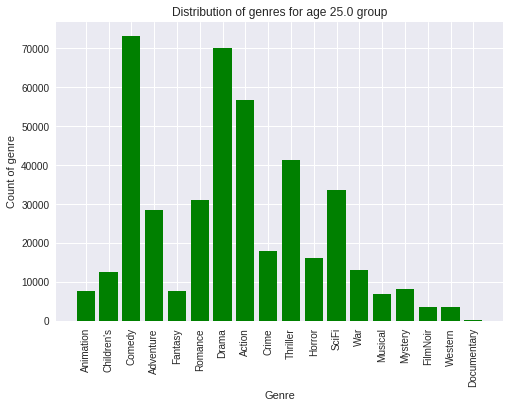

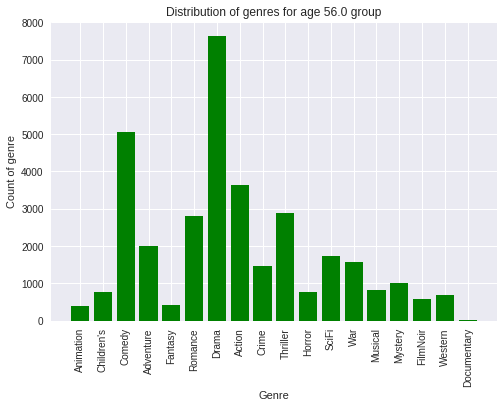

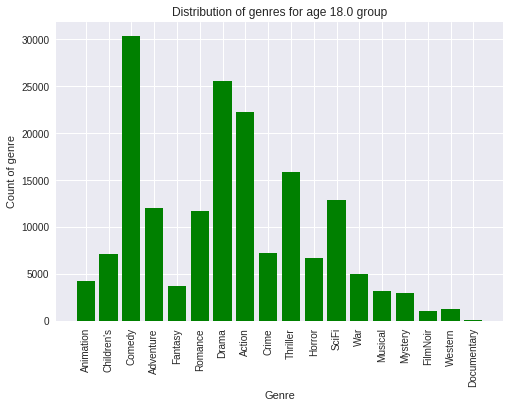

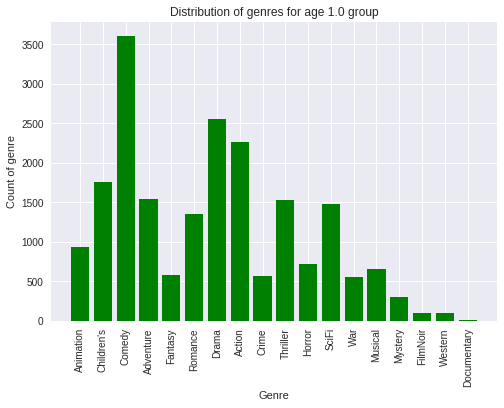

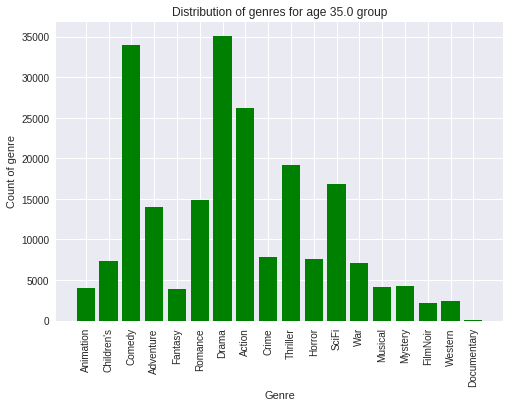

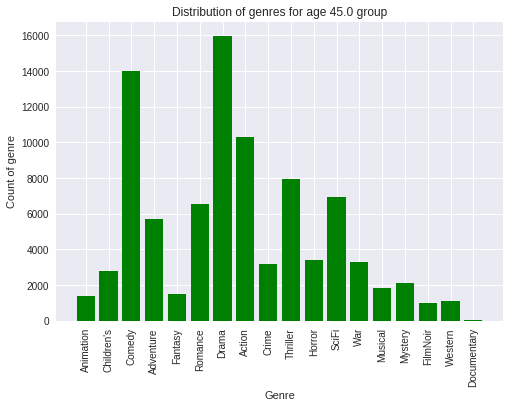

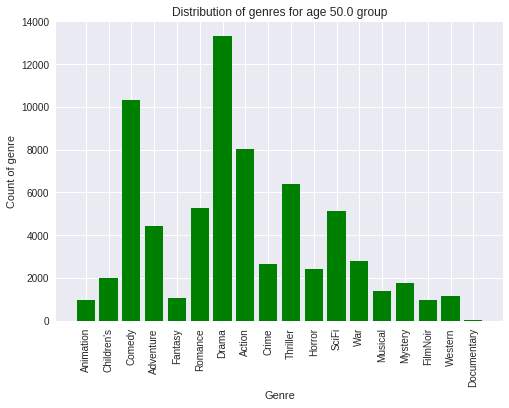

In [0]:
demo_genre_distribution('age')

<div class="alert alert-block alert-info">
    The overall trend for all age groups are quite similar, with the top genres being *Comedy*, *Drama* and *Action*. Inspecting them closely reveal some differences between these age groups. 
    <ul>
        <li>Audiences below age 45 are more likely to watch Comedy and Action genres while those above 45 years old tend to watch Drama movies more often.</li>
        <li>Audiences below age 18 have a tendency towards Children and Animation genres.</li>
    </ul>
    
    These observations lead us to think that there might be a correlation between age and the preferences of the audience.
</div>

##### Occupation vs Genres

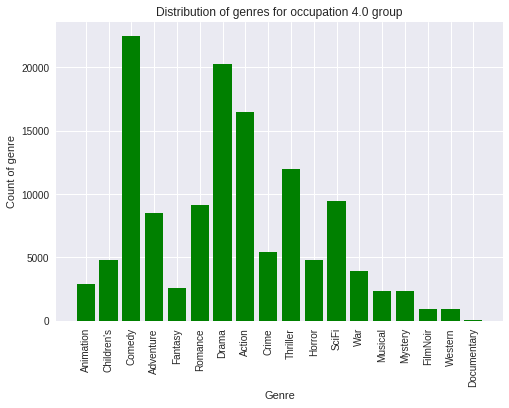

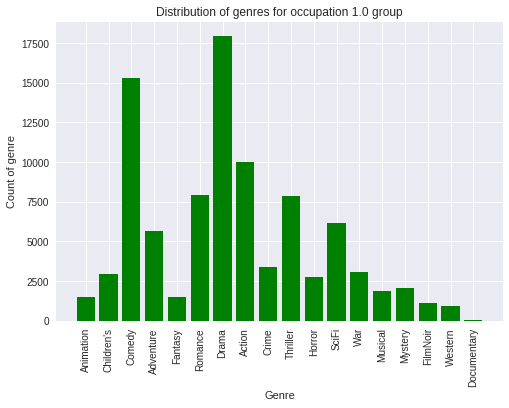

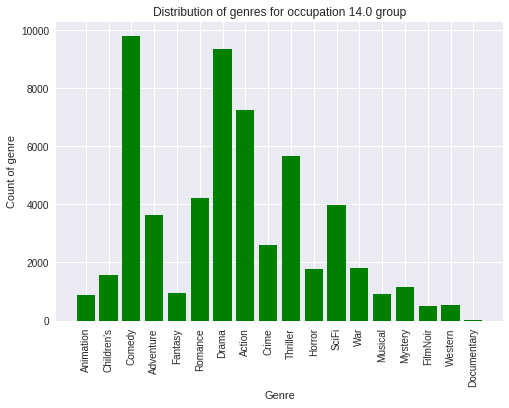

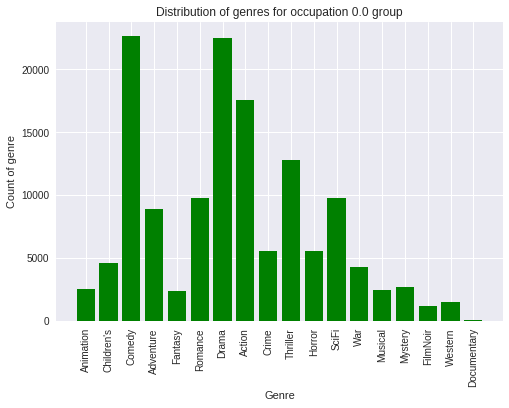

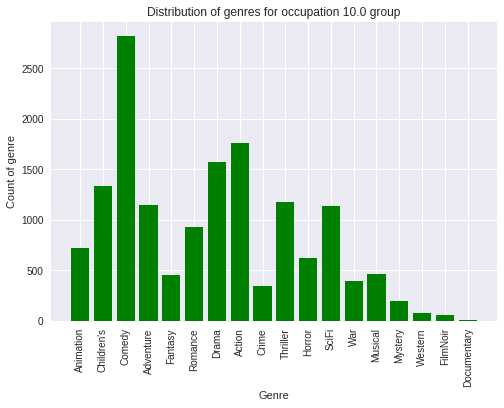

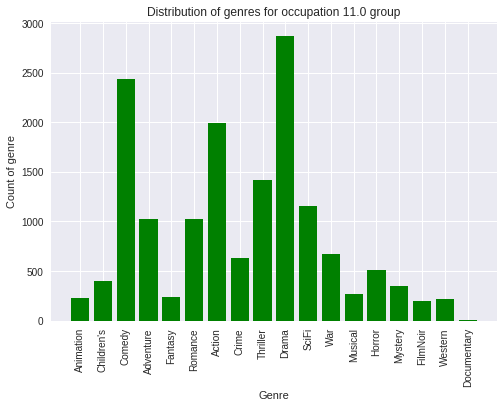

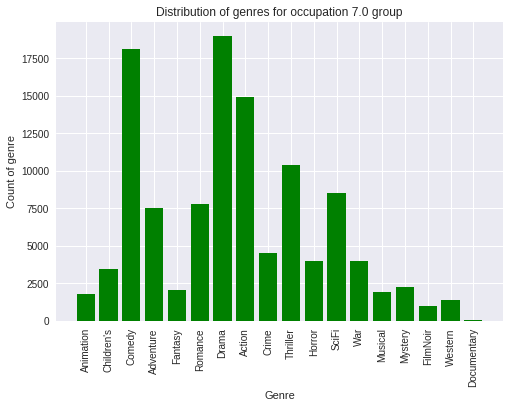

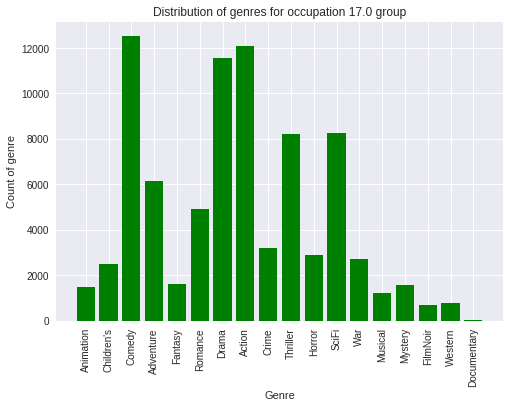

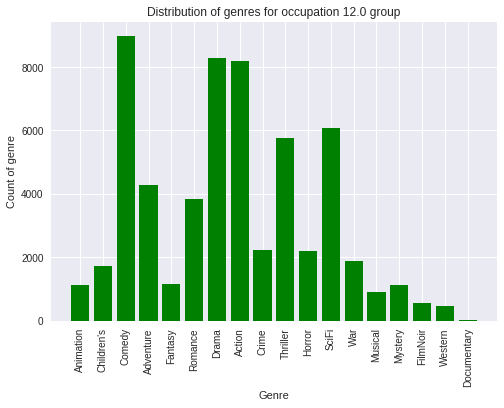

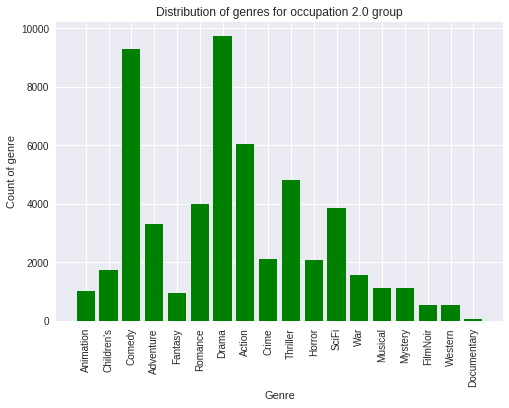

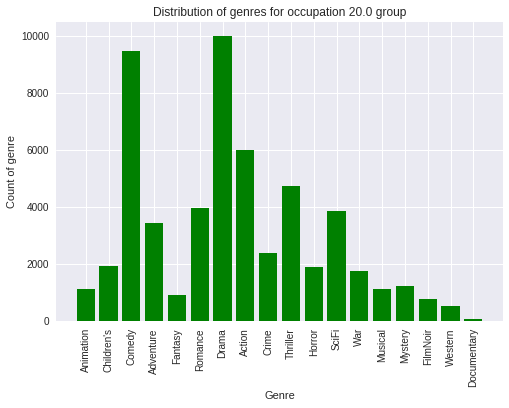

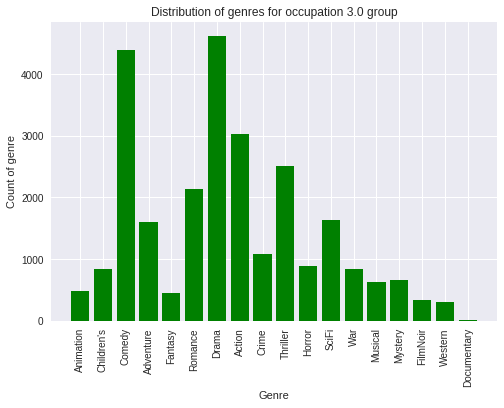

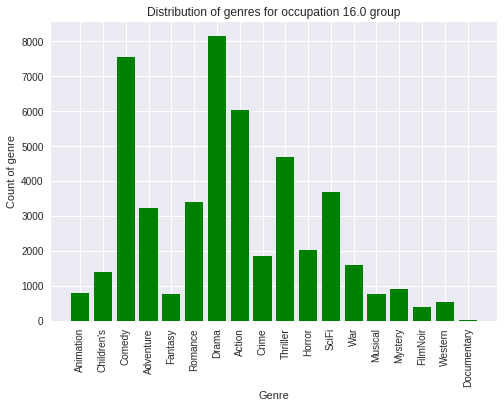

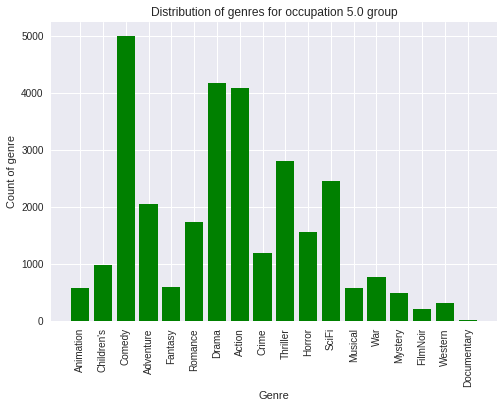

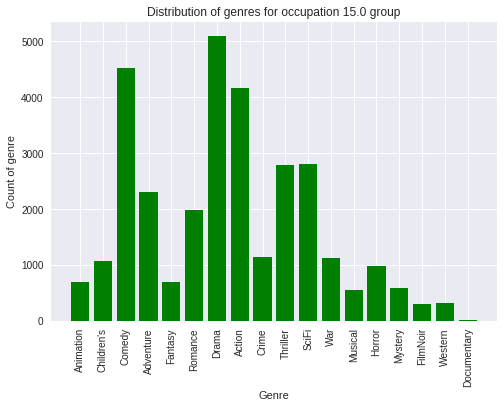

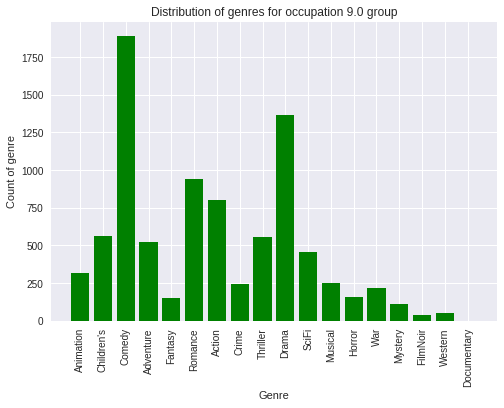

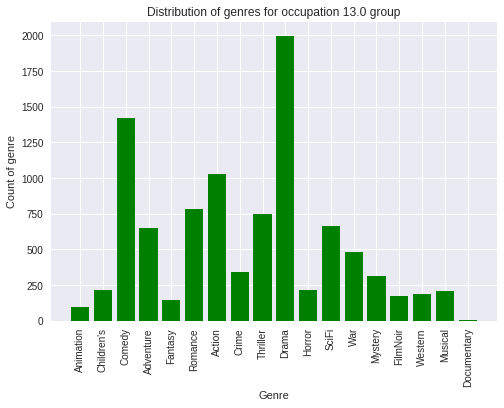

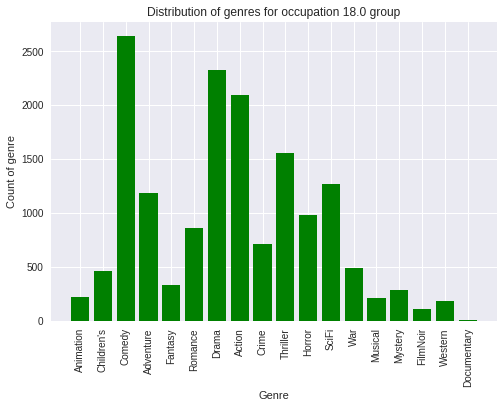

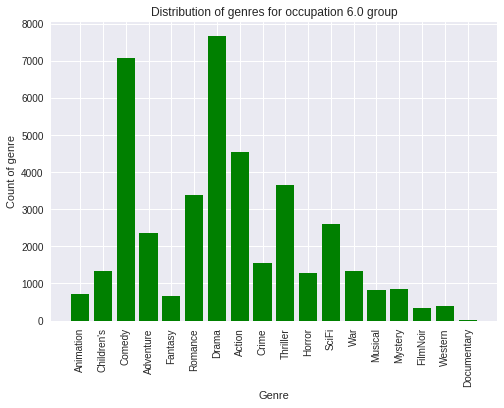

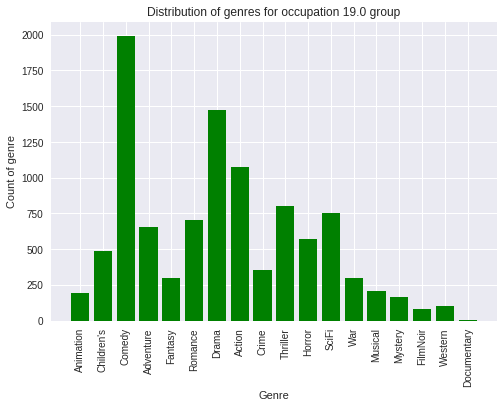

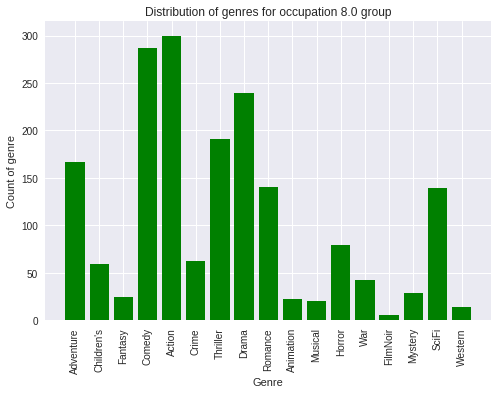

In [0]:
demo_genre_distribution('occupation')

<div class="alert alert-block alert-info">
    The overall distribution for each occupation is relatively similar to each other with the same top few genres as mentioned above. On closer inspection, we do observe some minor differences between each occupation. However, since these differences are minor, they may not be significant. Thus, this lead us to hypothese that there might be a weak correlation between occupation and genres. Further study needs to be carried out to study the relatinship between users' demographic information and movie genres to determine users' preferences. This is when community detection comes in.
</div>

## 4. Correlation Study

This section evalutates the qualitative correlations between predictors and ratings

**4.1 Correlation plots for numerical variables**

In [0]:
master_data[["year","sentiment","subjectivity","rating"]].corr()

,year,sentiment,subjectivity,rating
year,1.000000,-0.261625,-0.027829,-0.153669
sentiment,-0.261625,1.000000,0.485394,0.296028
subjectivity,-0.027829,0.485394,1.000000,0.098929
rating,-0.153669,0.296028,0.098929,1.000000


This correlation plot illustrates correlation of numerical variables. There is high correlation between movie tags' subjectivity scores and movie ratings.

**4.2 Heatmap for categorical variables**

In [0]:
age_occupation=pd.pivot_table(master_data,index=["occupation"],values=["rating"],columns=["age"],aggfunc=[np.mean],fill_value=0)
#age_occupation

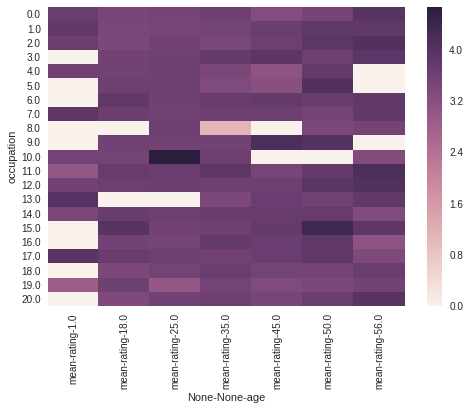

In [0]:
sns.heatmap(age_occupation, fmt=".1f")
plt.show()

From the heat map, we can observe that age and occupations are correlated. Certain occuptations are concentrated for specific age groups. For example, college student is the most popular occupation for students between 25 to 35 years. Distribution of occupations is skewed for users under 18 as they are below legal working ages and are mostly students.

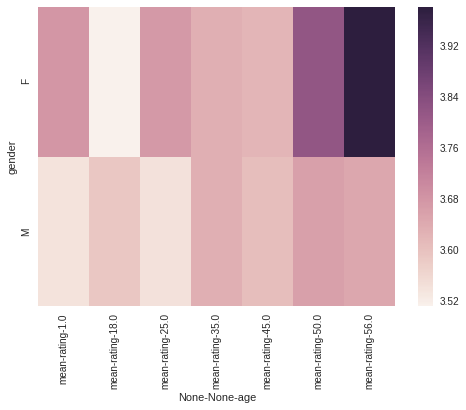

In [0]:
age_gender=pd.pivot_table(master_data,index=["gender"],values=["rating"],columns=["age"],aggfunc=[np.mean],fill_value=0)
sns.heatmap(age_gender, fmt=".1f")
plt.show()

Age and gender is correlated. Users above 55 are mostly females. There is an even gender distribution among users between 35 to 45.

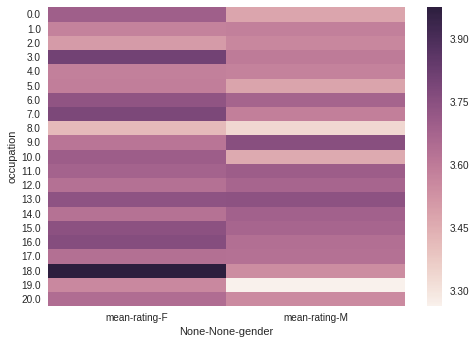

In [0]:
occupation_gender=pd.pivot_table(master_data,index=["occupation"],values=["rating"],columns=["gender"],aggfunc=[np.mean],fill_value=0)
sns.heatmap(occupation_gender, fmt=".1f")
plt.show()

There is correlation among the three users' demographic variables but it is difficult to divide the users into dfferent groups based on these three variables alone, this further proves the need for community detections. 

## 5. Chi-Square Test

**Chi-Square Test between age and rating**

In [0]:
#Correlation between age and rating
age_rating_tab=pd.crosstab(master_data['age'],master_data['rating'], 
                                margins = True)
age_rating_tab.columns = ["1.0","2.0","3.0","4.0","5.0","row_totals"]
age_rating_tab.index = ["Below 18","18 to 25","25 to 35","35 to 45","45 to 50","50 to 56","above 56","col_totals"]
age_rating_tab
observed=age_rating_tab.ix[0:7,0:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [0]:
expected =  np.outer(age_rating_tab["row_totals"][0:7],
                     age_rating_tab.ix["col_totals"][0:5]) / 482073

expected = pd.DataFrame(expected)
expected
expected.columns= ["1.0","2.0","3.0","4.0","5.0"]
expected.index = ["Below 18","18 to 25","25 to 35","35 to 45","45 to 50","50 to 56","above 56"]

expected

,1.0,2.0,3.0,4.0,5.0
Below 18,495.047576,948.713348,2375.864734,3174.959664,2121.816447
18 to 25,4314.776111,8268.873320,20707.755979,27672.572859,18493.501159
25 to 35,10939.575427,20964.694590,52501.926555,70160.349065,46887.960267
35 to 45,5336.699622,10227.296154,25612.238196,34226.621576,22873.553138
45 to 50,2293.377028,4395.047074,11006.525169,14708.444024,9829.611001
50 to 56,1809.553422,3467.843437,8684.527248,11605.468659,7755.901455
above 56,911.039361,1745.923514,4372.319744,5842.899482,3904.792984


In [0]:
def chi_square_data(observed,expected,dfn):
    chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                          df = dfn)   # *
    print("Critical value")
    print(crit)
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                                 df=dfn)
    print("P value")
    print(p_value)

In [0]:
chi_square_data(observed,expected,12)

Critical value
21.02606981748307
P value
0.0


<div class="alert alert-block alert-info">
P value equal to zero suggests stong correlations between age groups and ratings.
</div>

**Chi-square-test for gender and rating**

In [0]:
gender_rating_tab=pd.crosstab(master_data['gender'],master_data['rating'], 
                                margins = True)
gender_rating_tab.columns = ["1.0","2.0","3.0","4.0","5.0","row_totals"]
gender_rating_tab.index = ["Female","Male","col_totals"]
gender_rating_tab
observed=gender_rating_tab.ix[0:2,0:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [0]:
expected =  np.outer(gender_rating_tab["row_totals"][0:2],
                     gender_rating_tab.ix["col_totals"][0:5]) / 482073


expected = pd.DataFrame(expected)
expected
expected.columns= ["1.0","2.0","3.0","4.0","5.0"]
expected.index = ["Female","Male"]

expected

,1.0,2.0,3.0,4.0,5.0
Female,6620.515773,12687.612250,31773.612710,42460.303937,28376.09947
Male,19479.552775,37330.779187,93487.544915,124931.011392,83491.03698


In [0]:
observed

,1.0,2.0,3.0,4.0,5.0
Female,6184,12038,30627,42911,30340
Male,19955,38055,94821,124730,81694


In [0]:
    chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                          df = 7)   # *

    print("Critical value")
    print(crit)

    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                                 df=7)
    print("P value")
    print(p_value)

Critical value
14.067140449340169
P value
0.0


This suggests that there is high correlation between gender and ratings

**Chi-Sqaure Test between age and rating**

In [0]:
#Correlation between age and rating
job_rating_tab=pd.crosstab(master_data['occupation'],master_data['rating'], 
                                margins = True)
job_rating_tab.columns = ["1.0","2.0","3.0","4.0","5.0","row_totals"]

job_rating_tab.index = ["Job_1","Job_2","Job_3","Job_4","Job_5","Job_6","Job_7","Job_7","Job_8","Job_9","Job_10","Job_11","Job_12","Job_13","Job_14","Job_15","Job_16","Job_17","Job_18","Job_19","Job_20","col_totals"]
job_rating_tab
observed=job_rating_tab.ix[0:20,0:5]


expected =  np.outer(job_rating_tab["row_totals"][0:20],
                     job_rating_tab.ix["col_totals"][0:5]) / 482073


expected = pd.DataFrame(expected)

expected.columns= ["1.0","2.0","3.0","4.0","5.0"]
expected.index = ["Job_1","Job_2","Job_3","Job_4","Job_5","Job_6","Job_7","Job_8","Job_9","Job_10","Job_11","Job_12","Job_13","Job_14","Job_15","Job_16","Job_17","Job_18","Job_19","Job_20"]



import scipy.stats as stats
def chi_square_data(observed,expected,dfn):
    chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
    crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                          df = dfn)   # *

    print("Critical value")
    print(crit)

    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                                 df=dfn)
    print("P value")
    print(p_value)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [0]:
chi_square_data(observed,expected,25)

Critical value
37.65248413348277
P value
0.0


This suggests that there is high correlation between job occupations and ratings.

P-values for all the tests are zero suggesting that categorical variables which are ages, genders, occputation are all highly correlated to rating, suggesting there is a need to include all these variables in the prediction model for rating. 

---